In [ ]:
%%capture
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

In [1]:
import os

def list_dir(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f'{indent}{os.path.basename(root)}/')


list_dir('./hymenoptera_data')

hymenoptera_data/
    train/
        ants/
        bees/
    val/
        ants/
        bees/


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy

plt.ion() 

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

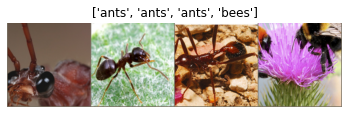

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss, train_acc = [], []
    val_loss, val_acc = [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()


                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train':
              train_loss.append(epoch_loss)
              train_acc.append(epoch_acc.item())
            else:
              val_loss.append(epoch_loss)
              val_acc.append(epoch_acc.item())


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, train_acc,val_loss,val_acc

In [6]:
def visualize_model_performance(train, val ,title):
  plt.plot([i+1 for i in range(len(train))],train,"-b", marker = 'o', label="train")
  plt.plot([i+1 for i in range(len(val))], val,"-r", marker = '*', label="val")
  plt.xlabel('Epochs')
  plt.ylabel(title)
  plt.title(title)
  plt.show()

In [7]:
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Fine-tuning Pre-trained ResNet

In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [9]:
model_ft,train_loss, train_acc,val_loss,val_acc = train_model(model_ft, criterion, optimizer_ft,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6765 Acc: 0.6762
val Loss: 0.5666 Acc: 0.7582

Epoch 1/24
----------
train Loss: 0.7296 Acc: 0.7131
val Loss: 0.2442 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.6917 Acc: 0.7746
val Loss: 0.3237 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.5048 Acc: 0.7869
val Loss: 0.2874 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.4960 Acc: 0.8156
val Loss: 0.2743 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.3871 Acc: 0.8402
val Loss: 0.2251 Acc: 0.9216

Epoch 6/24
----------
train Loss: 0.4088 Acc: 0.8238
val Loss: 0.2629 Acc: 0.9020

Epoch 7/24
----------
train Loss: 0.5232 Acc: 0.8074
val Loss: 0.2617 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.6035 Acc: 0.8115
val Loss: 0.5413 Acc: 0.8497

Epoch 9/24
----------
train Loss: 0.4520 Acc: 0.8238
val Loss: 0.9607 Acc: 0.7124

Epoch 10/24
----------
train Loss: 0.8937 Acc: 0.7254
val Loss: 0.7017 Acc: 0.7778

Epoch 11/24
----------
train Loss: 0.5252 Acc: 0.8238
val Loss: 0.3276 Acc: 0.9085

Ep

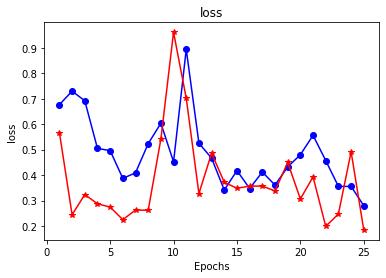

In [10]:
visualize_model_performance(train_loss, val_loss, 'loss')

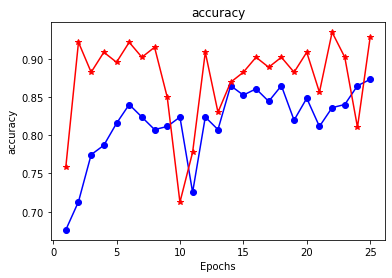

In [11]:
visualize_model_performance(train_acc,val_acc,'accuracy')

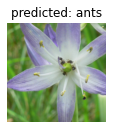

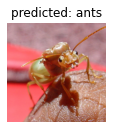

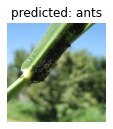

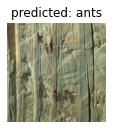

In [12]:
visualize_model(model_ft)

## Pre-trained Model as Feature Extractor: Linear Probing

In [13]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

In [14]:
model_ft,train_loss, train_acc,val_loss,val_acc = train_model(model_conv, criterion, optimizer_ft,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6804 Acc: 0.6025
val Loss: 0.7423 Acc: 0.4967

Epoch 1/24
----------
train Loss: 0.6971 Acc: 0.5451
val Loss: 0.7397 Acc: 0.4967

Epoch 2/24
----------
train Loss: 0.6762 Acc: 0.5697
val Loss: 0.7520 Acc: 0.4771

Epoch 3/24
----------
train Loss: 0.7009 Acc: 0.5656
val Loss: 0.7390 Acc: 0.5229

Epoch 4/24
----------
train Loss: 0.6967 Acc: 0.5533
val Loss: 0.7296 Acc: 0.5294

Epoch 5/24
----------
train Loss: 0.7020 Acc: 0.5656
val Loss: 0.7431 Acc: 0.4771

Epoch 6/24
----------
train Loss: 0.7082 Acc: 0.5533
val Loss: 0.7333 Acc: 0.5229

Epoch 7/24
----------
train Loss: 0.7027 Acc: 0.5410
val Loss: 0.7590 Acc: 0.4771

Epoch 8/24
----------
train Loss: 0.7196 Acc: 0.5574
val Loss: 0.7386 Acc: 0.5163

Epoch 9/24
----------
train Loss: 0.7223 Acc: 0.5041
val Loss: 0.7536 Acc: 0.5098

Epoch 10/24
----------
train Loss: 0.7019 Acc: 0.5328
val Loss: 0.7403 Acc: 0.5425

Epoch 11/24
----------
train Loss: 0.7075 Acc: 0.5451
val Loss: 0.7365 Acc: 0.5229

Ep

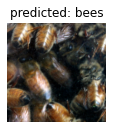

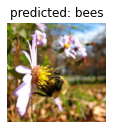

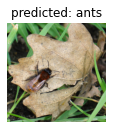

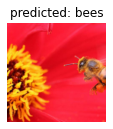

In [15]:
visualize_model(model_ft)

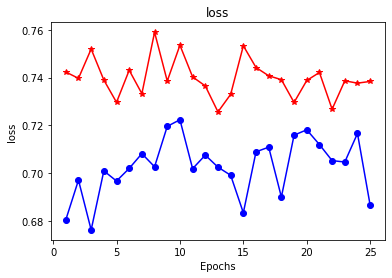

In [16]:
visualize_model_performance(train_loss, val_loss, 'loss')

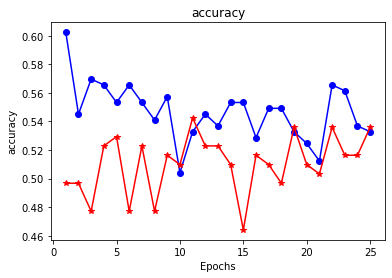

In [17]:
visualize_model_performance(train_acc,val_acc,'accuracy')

## Random Initialisation (Not-Pretrained)

In [18]:
model_conv = torchvision.models.resnet18(pretrained=False)

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)


In [19]:
model_ft,train_loss, train_acc,val_loss,val_acc = train_model(model_conv, criterion, optimizer_ft,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7468 Acc: 0.4713
val Loss: 0.7906 Acc: 0.4379

Epoch 1/24
----------
train Loss: 0.7475 Acc: 0.4836
val Loss: 0.8033 Acc: 0.4379

Epoch 2/24
----------
train Loss: 0.7573 Acc: 0.4877
val Loss: 0.8186 Acc: 0.4444

Epoch 3/24
----------
train Loss: 0.7412 Acc: 0.4959
val Loss: 0.8149 Acc: 0.4379

Epoch 4/24
----------
train Loss: 0.7468 Acc: 0.4590
val Loss: 0.8036 Acc: 0.4379

Epoch 5/24
----------
train Loss: 0.7454 Acc: 0.4795
val Loss: 0.8131 Acc: 0.4379

Epoch 6/24
----------
train Loss: 0.7536 Acc: 0.4631
val Loss: 0.8097 Acc: 0.4379

Epoch 7/24
----------
train Loss: 0.7473 Acc: 0.4959
val Loss: 0.8103 Acc: 0.4314

Epoch 8/24
----------
train Loss: 0.7446 Acc: 0.4754
val Loss: 0.8079 Acc: 0.4444

Epoch 9/24
----------
train Loss: 0.7387 Acc: 0.4877
val Loss: 0.8160 Acc: 0.4444

Epoch 10/24
----------
train Loss: 0.7456 Acc: 0.4631
val Loss: 0.8039 Acc: 0.4379

Epoch 11/24
----------
train Loss: 0.7529 Acc: 0.4877
val Loss: 0.8186 Acc: 0.4510

Ep

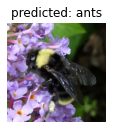

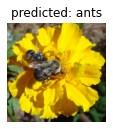

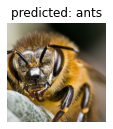

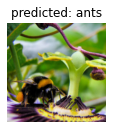

In [20]:
visualize_model(model_ft)

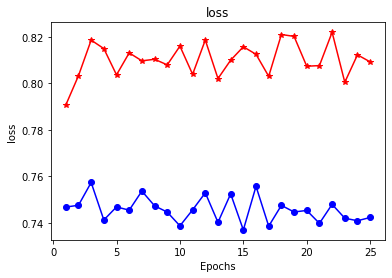

In [21]:
visualize_model_performance(train_loss, val_loss, 'loss')

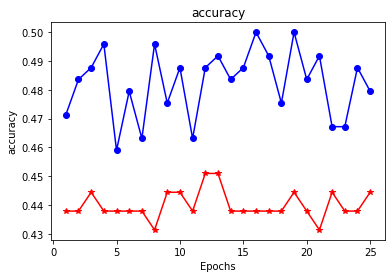

In [22]:
visualize_model_performance(train_acc,val_acc,'accuracy')